In [28]:
import pandas as pd
import numpy as np

from pathlib import Path
import os

import warnings
warnings.filterwarnings('ignore')

DATA_PATH = Path.cwd() / 'data/processed'

data_name = 'FA19 - FA23 Demographic Cleaned Dataset.csv'

In [ ]:
# load data
enrolled_gpas_online_fafsa_hs = pd.read_csv(f'{DATA_PATH}/{data_name}')

enrolled_gpas_xgb = enrolled_gpas_online_fafsa_hs[['enrolled', 'stype', 'gender', 'ethn_desc', 'resd', 'fully_online',
                                       'acd_std_desc', 'age', 'term_att_crhr', 'term_earn_crhr', 'term_gpa',
                                       'inst_gpa', 'inst_earned', 'no_pell', 'pell', 'subsidized', 'unsubsidized', 
                                       'summer_plus', 'kansas_promise', 'all_fafsa', 'hs_matriculation']]


In [1]:
%%writefile data_preparation.py
import pandas as pd
import numpy as np

def load_and_prepare_data(data_path):
    
    """
    Returns dataframe ready for XGBoost model.

    Parameters:
        data_path (str): Path to cleaned dataframe from data preparation (enrolled_gpas_online_fafsa_hs).

    Returns:
        pd.Dataframe: Modifed dataframe set up for XGBoost model.
    """

    # Load data
    df = pd.read_csv(data_path)

    df = df[['enrolled', 'stype', 'gender', 'ethn_desc', 'resd', 'fully_online',
             'acd_std_desc', 'age', 'term_att_crhr', 'term_earn_crhr', 'term_gpa',
             'inst_gpa', 'inst_earned', 'no_pell', 'pell', 'subsidized', 'unsubsidized', 
             'summer_plus', 'kansas_promise', 'all_fafsa', 'hs_matriculation']]

    # Filter and encode data
    df['enrolled'] = [1 if i == 'Enrolled' else 0 for i in df['enrolled']]
    df = df[df['resd'] != 'Z']
    df['hs_matriculation'] = df['hs_matriculation'].fillna('Not From HS')
    df = df[(df['age'] <= 60) & (df['age'] >= 10)]
    df = df[df['ethn_desc'] != 'DO NOT USE - Hispanic']

    return df

Overwriting data_preparation.py


In [2]:
%%writefile model_training.py
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

from data_preparation import load_and_prepare_data

def train_xgboost_model(prepped_xgb, response, params):
    """
    Parameters:
        prepped_xgb (pd.DataFrame): Dataframe prepped for XGBoost.
        response (str): String of response variable name.
        params (dict): Parameters for GridSearch.
        
    Returns:
        XGBoost Model: Returns best xgboost model
        grid_search.best_params_: Returns ideal parameters for model

    """
    # Split data
    X = prepped_xgb.drop(response, axis = 1)
    y = prepped_xgb[response]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

    # Encode categorical vars
    le = LabelEncoder()
    for col in X_train.columns:
        if X_train[col].dtype == 'object':
            X_train[col] = le.fit_transform(X_train[col].astype(str))
            X_test[col] = le.transform(X_test[col].astype(str))

    # Initialize and tune model
    xgb_clf = xgb.XGBClassifier(objective = 'binary:logistic', seed = 101)
    grid_search = GridSearchCV(
        xgb_clf, param_grid = params, cv = 5, n_jobs = -1, scoring = 'accuracy'
    )
    grid_search.fit(X_train, y_train)

    # Evaluate model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print('Best Parameters:', grid_search.best_params_)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Classification Report:\n', classification_report(y_test, y_pred))

    return best_model, grid_search.best_params_
    

Overwriting model_training.py


In [ ]:
# Run function to make sure it is operating appropriately
train_xgboost_model(prepped_xgb, 
                    response = 'enrolled',
                    params = {
                        'max_depth': [3, 4, 5],
                        'learning_rate': [0.1, 0.01, 0.001],
                        'n_estimators': [100, 500, 1000],
                        'colsample_bytree': [0.7, 0.8, 0.9],
                        'subsample': [0.7, 0.8, 0.9]
                    })

In [3]:
%%writefile run_training.py

from pathlib import Path
import joblib
from data_preparation import load_and_prepare_data
from model_training import train_xgboost_model

if __name__ == "__main__":
    # Paths
    DATA_PATH = f'{Path.cwd()}/data/processed/FA19 - FA23 Demographic Cleaned Dataset.csv'
    MODEL_PATH = Path.cwd()/'models/xgb_retention_model.pkl'

    # load and prepare data
    data = load_and_prepare_data(DATA_PATH)

    # Define model params
    params = {
                        'max_depth': [3, 4, 5],
                        'learning_rate': [0.1, 0.01, 0.001],
                        'n_estimators': [100, 500, 1000],
                        'colsample_bytree': [0.7, 0.8, 0.9],
                        'subsample': [0.7, 0.8, 0.9]
                    }

    # Train model
    best_model, best_params = train_xgboost_model(data, response = 'enrolled', params = params)

    # Save trained model
    MODEL_PATH.parent.mkdir(parents = True, exist_ok = True)
    joblib.dump(best_model, MODEL_PATH)
    

Writing run_training.py


In [4]:
%run run_training.py

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.9}
Accuracy: 0.7506949270326616
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.85      0.80      3459
           1       0.73      0.60      0.66      2297

    accuracy                           0.75      5756
   macro avg       0.74      0.73      0.73      5756
weighted avg       0.75      0.75      0.75      5756



In [31]:
%%writefile prediction.py
import pandas as pd
from pathlib import Path
import joblib
from sklearn.preprocessing import LabelEncoder

def preprocess_data(input_data, model_features, categorical_features):
    """
    Preprocesses new input data for the trained model.

    Parameteres:
        input_data (pd.DataFrame): New data to run predictions on.
        model_features (list): The list of features used during training.
        categorical_features (list): The list of categorical features that need encoding.

    Returns:
        Pd.DataFrame: Preprocessed data ready for prediction.
    """
    # Select only the features used for training
    input_data = input_data[model_features]

    # Encode categorical variables
    le = LabelEncoder()
    for col in categorical_features:
        if col in input_data.columns:
            input_data[col] = le.fit_transform(input_data[col].astype(str))

    return input_data

def load_model(model_path):
    """
    Loads the trained model from a pickle file.

    Parameters:
        model_path (str): Path to pickle file.

    Returns:
        Trained model

    """
    return joblib.load(model_path)

def predict(model, preprocessed_data):
    """
    Uses the trained model to make predictions on the new data.

    Parameters:
        model: The trained model.
        preprocessed_data (pd.DataFrame): Preprocessed data ready for prediction.

    Returns:
        np.ndarray: Predictions made by the model.

    """
    return model.predict(preprocessed_data)

if __name__ == "__main__":
    MODEL_PATH = Path.cwd() / 'models/xgb_retention_model.pkl'
    INPUT_DATA_PATH = Path.cwd() / 'data/new_data/new_cleaned_data.csv'
    OUTPUT_PATH = Path.cwd() / 'data/predictions/predictions.csv'

    # Load the model
    model = load_model(MODEL_PATH)

    # Load new data
    new_data = pd.read_csv(INPUT_DATA_PATH)

    # Define features
    model_features = ['stype', 'gender', 'ethn_desc', 'resd', 'fully_online', 'acd_std_desc', 'age', 
                      'term_att_crhr', 'term_earn_crhr', 'term_gpa', 'inst_gpa', 'inst_earned', 'no_pell',
                      'pell', 'subsidized', 'unsubsidized', 'summer_plus', 'kansas_promise', 'all_fafsa', 
                      'hs_matriculation']

    # Isolate categorical features
    cat_features = ['stype', 'gender', 'ethn_desc', 'resd', 'fully_online', 'acd_std_desc', 'hs_matriculation']

    # Preporcess new data
    preprocessed_data = preprocess_data(new_data, model_features, cat_features)

    # Generate predictions
    predictions = predict(model, preprocessed_data)

    # Save predictions
    output = new_data.copy()
    output['predicted_enrollment'] = predictions
    OUTPUT_PATH.parent.mkdir(parents = True, exist_ok = True)
    output.to_csv(OUTPUT_PATH, index = False)


Writing prediction.py


 Accuracy: 0.8018443804034582
 Specificity: 0.8898061048185832
 Confusion Matrix: [[4635  574]
 [1145 2321]]


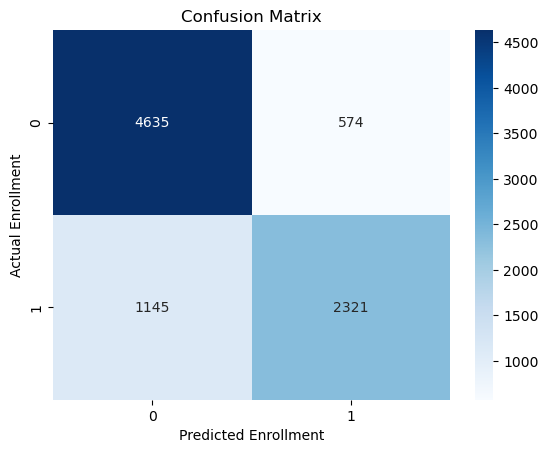

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# calc accuracy
output['enrolled_num'] = [1 if i == 'Enrolled' else 0 for i in output['enrolled']]
acc = accuracy_score(output['enrolled_num'], output['predicted_enrollment'])
cm = confusion_matrix(output['enrolled_num'], output['predicted_enrollment'])

TN, FP, FN, TP = cm.ravel()

# Calculate specificity
specificity = TN/(TN + FP)
print(f' Accuracy: {acc}\n Specificity: {specificity}\n Confusion Matrix: {cm}', sep = "")

# visualize cm
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted Enrollment')
plt.ylabel('Actual Enrollment')
plt.title('Confusion Matrix')
plt.show()